# Logistic Regression

In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
import torch as T
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from typing import Iterable

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'utils/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

class1 = (y_train == 1)
class0 = (y_train == 0)
classes = class0.astype(np.uint8) | class1.astype(np.uint8)

class1_ = (y_test == 1)
class0_ = (y_test == 0)
classes_ = class0_.astype(np.uint8) | class1_.astype(np.uint8)

# Subsample the data for more efficient code execution in this exercise
X_train = X_train[classes == True]
y_train = y_train[classes == True]

X_test = X_test[classes_ == True]
y_test = y_test[classes_ == True]

y_train = np.expand_dims(y_train, 0)
y_test = np.expand_dims(y_test, 0)

# Normalize images
X_train /= 255
X_test /= 255
X_train = np.rollaxis(X_train.reshape(-1, 32 * 32 * 3), 1, 0)
X_test = np.rollaxis(X_test.reshape(-1, 32 * 32 * 3), 1, 0)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (3072, 10000)
Training labels shape:  (1, 10000)
Test data shape:  (3072, 2000)
Test labels shape:  (1, 2000)


### Logistic Regression

**Mathematical expression of the algorithm**

For one example $x^{(i)}$
$$z^{(i)} = w^T x^{(i)} + b$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)})  \log(1-a^{(i)})$$
The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

First let's implement the sigmoid function and visualize the result to check the implementation.

Remember a sigmoid function is defined as:
$$\sigma(z) = \frac{1}{1+e^{-z}}$$

Hint: [click](https://pytorch.org/docs/stable/torch.html#torch.exp)

In [3]:
def sigmoid(z: T.Tensor) -> T.Tensor:
    """
    Compute the sigmoid of z
    """
    #### YOUR CODE STARTS HERE ####
    s = 1 / (1 + T.exp(-z))
    #### YOUR CODE ENDS HERE ####
    return s

In [4]:
tensor = T.tensor(9.2, device=device)
print('sigmoid(9.2) = ', sigmoid(T.tensor(9.2)))

tensor = T.tensor(0.0, device=device)
print('sigmoid(0) = ', sigmoid(T.tensor(0.0)))

sigmoid(9.2) =  tensor(0.9999)
sigmoid(0) =  tensor(0.5000)


**Expected Output:**
```
sigmoid(9.2) =  tensor(0.9999)
sigmoid(0) =  tensor(0.5000)
```

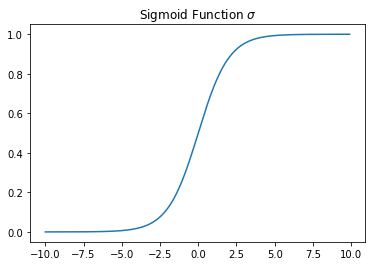

In [5]:
z = T.arange(-10, 10, 0.1, device=device)
s = sigmoid(z)
# print(type(z), type(s))
plt.figure(figsize=(6, 4))
plt.plot(z.cpu().numpy(), s.cpu().numpy())
plt.title('Sigmoid Function $\sigma$')
plt.show()

In [6]:
def initialize_with_zeros(dim: int, device: str) -> Iterable[T.Tensor]:
    """
    Argument:
    dim -- size of the w tensor
    
    Returns:
    W -- initialized tensor of shape (dim, 1) for weights
    b -- initialized tensor for the bias (scalar)
    """
    
    #### YOUR CODE STARTS HERE ####
    W = T.zeros([dim, 1], dtype=T.float32, device=device)
    b = T.tensor(0., device=device)
    #### YOUR CODE ENDS HERE ####

    return W, b

In [7]:
dim = 2
W, b = initialize_with_zeros(dim, device=device)
print(W)
print(b)

tensor([[ 0.],
        [ 0.]], device='cuda:0')
tensor(0., device='cuda:0')


**Expected Output:**
```
tensor([[ 0.],
        [ 0.]])
tensor(0.)
```

Recall that the propagation logistic regression is defined as:
$$Z = W^T X + b$$
$$\hat{Y} = A = sigmoid(Z)$$
$$\mathcal{L}(A, Y) = \frac{1}{m}(- Y  \log(A) - (1-Y)  \log(1-A))$$
$$\frac{\delta J}{\delta W} = \frac{1}{m}(X(A-Y)^T)$$
$$\frac{\delta J}{\delta b} = \frac{1}{m}(A-Y)^T$$

Hint: [click](https://pytorch.org/docs/stable/torch.html#torch.transpose)

In [8]:
def propagate(W, b, X, Y):
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    #### YOUR CODE STARTS HERE ####
    WT = T.transpose(W, 0, 1)
    Z = T.add(T.mm(WT, X), b)
    A = sigmoid(Z)  # compute activation
    cost = (- 1 / m) * T.sum(Y * T.log(A) + (1 - Y) * (T.log(1 - A)))  # compute cost
    #### YOUR CODE ENDS HERE ####
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    #### YOUR CODE STARTS HERE ####
    dW = (1 / m) * T.mm(X, T.transpose(A - Y, 0, 1))
    db = (1 / m) * T.sum(A - Y)
    #### YOUR CODE ENDS HERE ####

    grads = {'dW': dW,
             'db': db}
    
    return grads, cost

In [9]:
W, b = T.tensor([[1.],[2.]], device=device), T.tensor(2., device=device), 
X, Y = T.tensor([[1.,2.,-1.],[3.,4.,-3.2]], device=device), T.tensor([[1.,0.,1.]], device=device)
grads, cost = propagate(W, b, X, Y)
print('dW =', grads['dW'])
print('db =', grads['db'])
print('cost =', cost)

dW = tensor([[ 0.9985],
        [ 2.3951]], device='cuda:0')
db = tensor(1.00000e-03 *
       1.4556, device='cuda:0')
cost = tensor(5.7986, device='cuda:0')


**Expected Output:**
```
dW = tensor([[ 0.9985], [ 2.3951]])
db = tensor(1.00000e-03 * 1.4556)
cost = tensor(5.7986)
```

In [10]:
def optimize(W, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        #### YOUR CODE STARTS HERE ####
        grads, cost = propagate(W, b, X, Y)
        #### YOUR CODE ENDS HERE ####
        
        # Retrieve derivatives from grads
        dW = grads['dW']
        db = grads['db']
        
        # update rule (≈ 2 lines of code)
        #### YOUR CODE STARTS HERE ####
        W = W - learning_rate * dW  # need to broadcast
        b = b - learning_rate * db
        #### YOUR CODE ENDS HERE ####
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost.cpu().numpy())
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ('Cost after iteration %i: %f' % (i, cost.cpu().numpy()))
    
    params = {'W': W,
              'b': b}
    
    grads = {'dW': dW,
             'db': db}
    
    return params, grads, costs

In [11]:
params, grads, costs = optimize(W, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ('W =', params['W'])
print ('b =', params['b'])
print ('dW =', grads['dW'])
print ('db =', grads['db'])

W = tensor([[ 0.1903],
        [ 0.1226]], device='cuda:0')
b = tensor(1.9254, device='cuda:0')
dW = tensor([[ 0.6775],
        [ 1.4163]], device='cuda:0')
db = tensor(0.2192, device='cuda:0')


**Expected Output:**
```
W = tensor([[ 0.1903], [ 0.1226]])
b = tensor(1.9254)
dW = tensor([[ 0.6775], [ 1.4163]])
db = tensor(0.2192)
```

In [12]:
def predict(W, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    """
    
    m = X.shape[1]
    
    WT = T.transpose(W, 0, 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    #### YOUR CODE STARTS HERE ####
    A = sigmoid(T.mm(WT, X) + b)
    #### YOUR CODE ENDS HERE ####

    return A

In [13]:
predict(W, b, X)

tensor([[ 0.9999,  1.0000,  0.0045]], device='cuda:0')

**Expected Output:**
```
tensor([[ 0.9999,  1.0000,  0.0045]])
```

In [14]:
def model(X_train, Y_train, X_test, Y_test, device='cpu', num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    """
    
    #### YOUR CODE STARTS HERE ####
    # initialize parameters with zeros (≈ 1 line of code)
    W, b = initialize_with_zeros(X_train.shape[0], device=device)

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(W, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    W = parameters['W']
    b = parameters['b']
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = (predict(W, b, X_test).cpu().numpy() > 0.5).astype(np.uint8)
    Y_prediction_train = (predict(W, b, X_train).cpu().numpy() > 0.5).astype(np.uint8)
    #### YOUR CODE ENDS HERE ####

    # Print train/test Errors
    print('train accuracy: {} %'.format(100 - np.mean(np.abs(Y_prediction_train - Y_train.cpu().numpy())) * 100))
    print('test accuracy: {} %'.format(100 - np.mean(np.abs(Y_prediction_test - Y_test.cpu().numpy())) * 100))

    
    d = {'costs': costs,
         'Y_prediction_test': Y_prediction_test, 
         'Y_prediction_train' : Y_prediction_train, 
         'W' : W, 
         'b' : b,
         'learning_rate' : learning_rate,
         'num_iterations': num_iterations}
    
    return d

In [15]:
if device == 'cuda':
    X_train_T = T.from_numpy(X_train).float().cuda()
    y_train_T = T.from_numpy(y_train).float().cuda()
    X_test_T = T.from_numpy(X_test).float().cuda()
    y_test_T = T.from_numpy(y_test).float().cuda()
else:
    X_train_T = T.from_numpy(X_train).float()
    y_train_T = T.from_numpy(y_train).float()
    X_test_T = T.from_numpy(X_test).float()
    y_test_T = T.from_numpy(y_test).float()
    
X_train_T.size(), y_train_T.size()

(torch.Size([3072, 10000]), torch.Size([1, 10000]))

In [16]:
d = model(X_train_T, y_train_T, X_test_T, y_test_T, device=device, num_iterations=1500, learning_rate=0.01, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.502311
Cost after iteration 200: 0.473895
Cost after iteration 300: 0.460340
Cost after iteration 400: 0.451575
Cost after iteration 500: 0.445157
Cost after iteration 600: 0.440132
Cost after iteration 700: 0.436026
Cost after iteration 800: 0.432568
Cost after iteration 900: 0.429590
Cost after iteration 1000: 0.426980
Cost after iteration 1100: 0.424661
Cost after iteration 1200: 0.422578
Cost after iteration 1300: 0.420690
Cost after iteration 1400: 0.418965
train accuracy: 81.11000061035156 %
test accuracy: 81.74999952316284 %


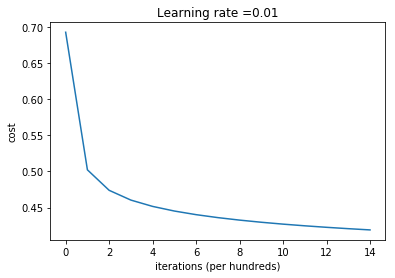

In [17]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.figure(figsize=(6, 4))
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Learning rate =' + str(d['learning_rate']))
plt.show()

learning rate is: 0.01
train accuracy: 83.48000049591064 %
test accuracy: 82.05000013113022 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 81.11000061035156 %
test accuracy: 81.74999952316284 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 77.77999937534332 %
test accuracy: 78.84999960660934 %

-------------------------------------------------------



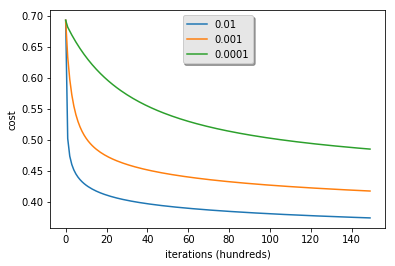

In [18]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ('learning rate is: ' + str(i))
    models[str(i)] = model(X_train_T, y_train_T, X_test_T, y_test_T, device=device, num_iterations=15000, learning_rate=i, print_cost=False)
    print ('\n' + '-------------------------------------------------------' + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]['costs']), label= str(models[str(i)]['learning_rate']))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Interpretation:

- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost).
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you:
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting.

learning rate is: 0.01
train accuracy: 81.11000061035156 %
test accuracy: 81.74999952316284 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 77.77999937534332 %
test accuracy: 78.84999960660934 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 72.27999866008759 %
test accuracy: 72.69999980926514 %

-------------------------------------------------------



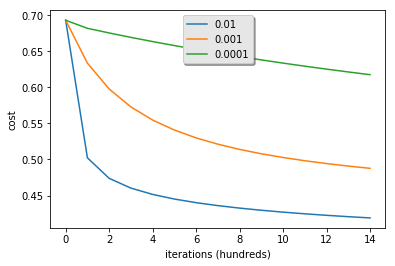

In [19]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ('learning rate is: ' + str(i))
    models[str(i)] = model(X_train_T, y_train_T, X_test_T, y_test_T, device=device, num_iterations=1500, learning_rate=i, print_cost=False)
    print ('\n' + '-------------------------------------------------------' + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]['costs']), label= str(models[str(i)]['learning_rate']))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()